<a href="https://colab.research.google.com/github/ravindulakshithaperera1995/test_ml_project/blob/develop/An_Approach_for_Crowd_Counting_and_Crowd_Density_Estimation_using_Aerial_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

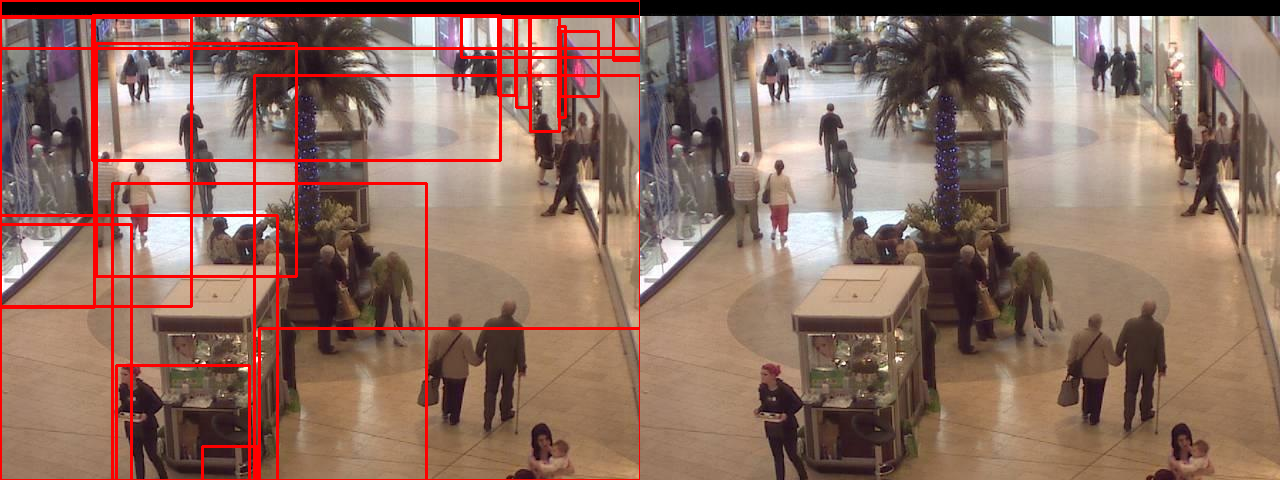

32/32 [==============================] - 515s 16s/step


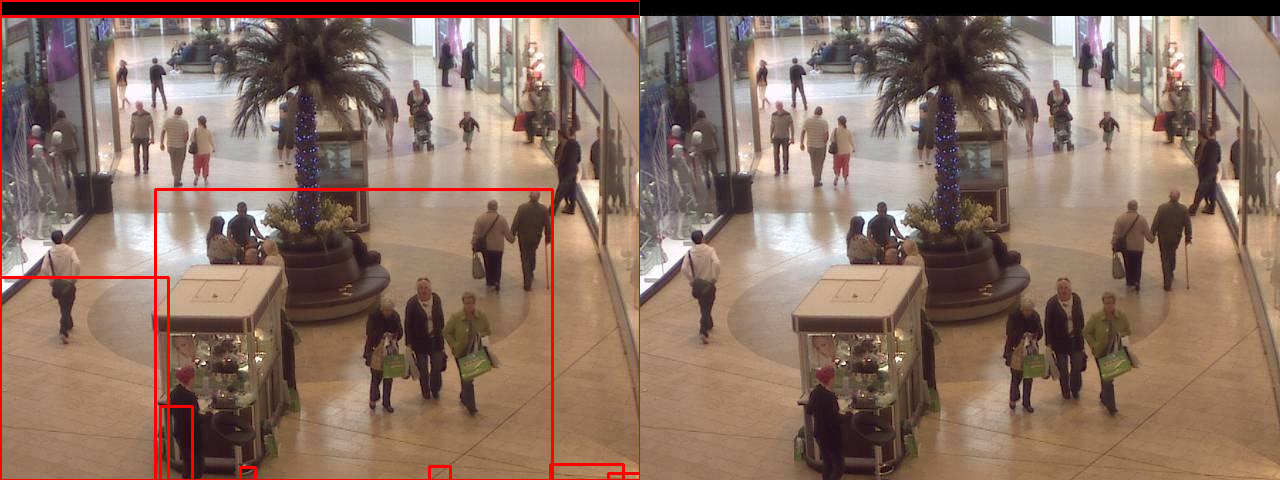

32/32 [==============================] - 510s 16s/step


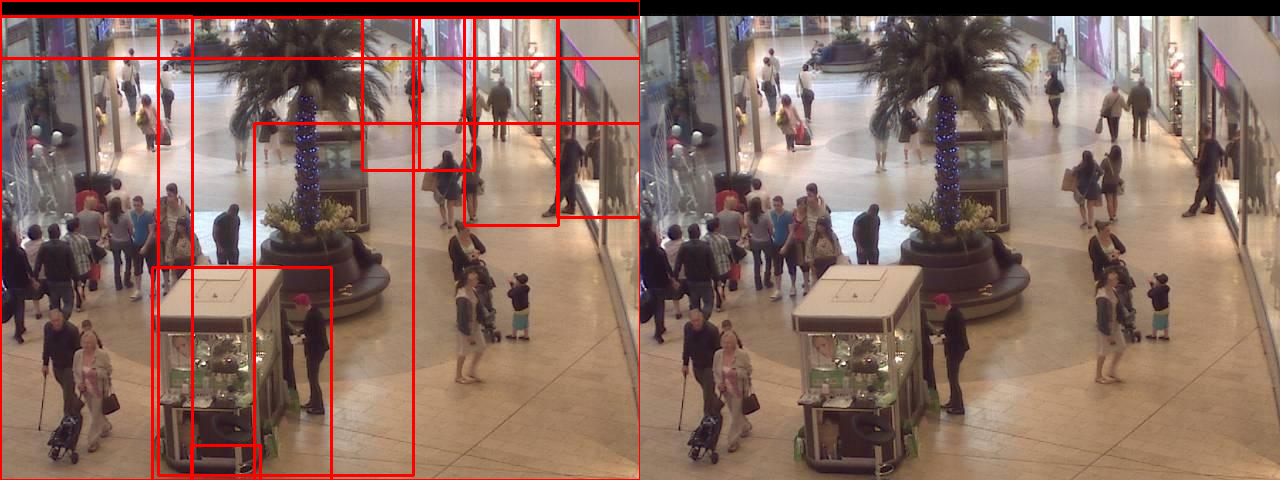

32/32 [==============================] - 508s 16s/step


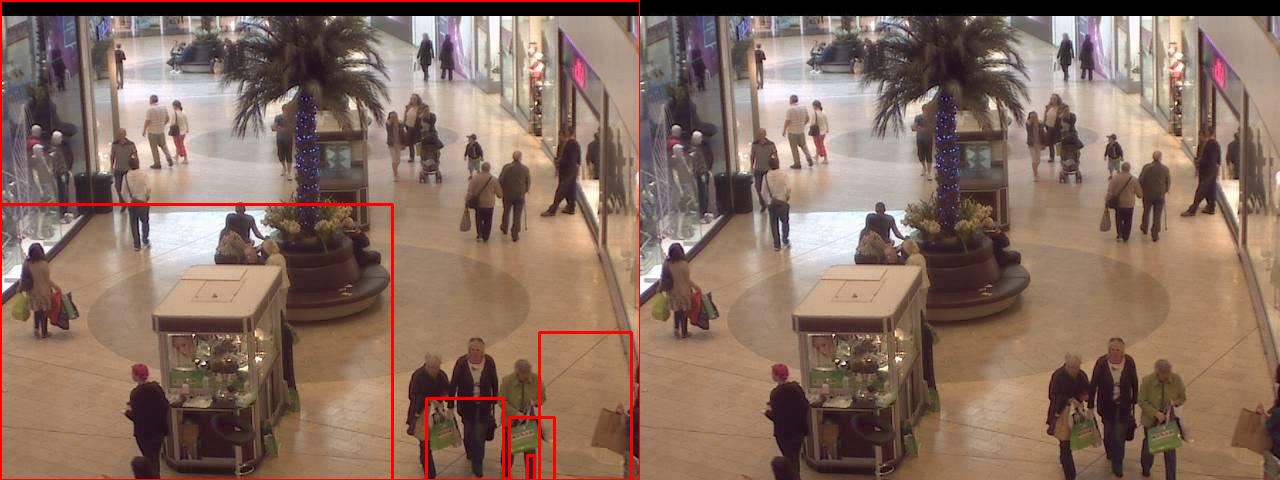

32/32 [==============================] - 508s 16s/step


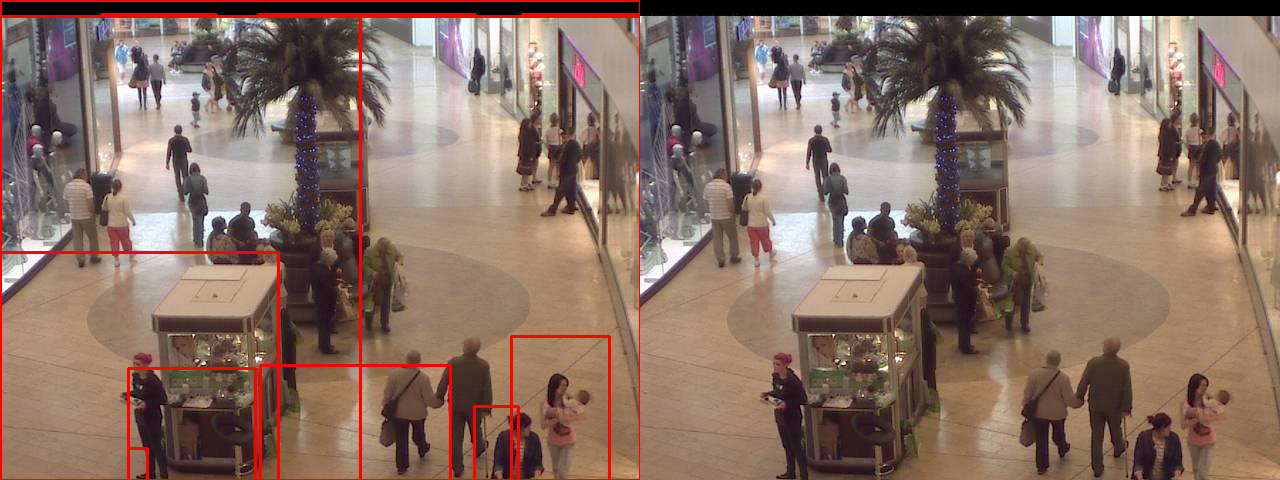

32/32 [==============================] - 504s 16s/step


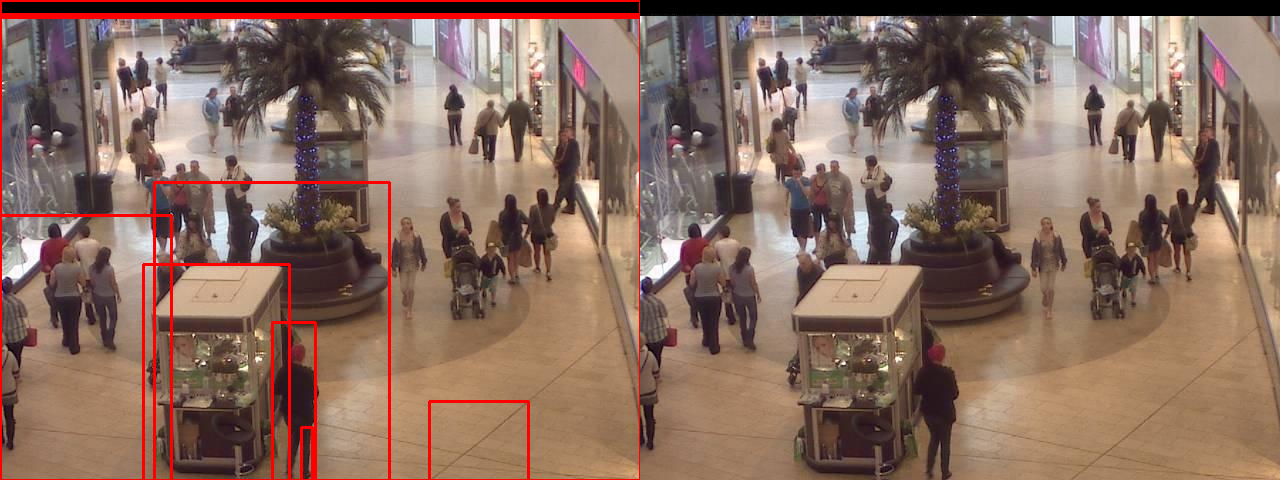

 9/32 [=======>......................] - ETA: 6:07

In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras import datasets, layers, models, regularizers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import os
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import pdb
from google.colab.patches import cv2_imshow

MODEL_PATH = os.path.sep.join(['/content/drive/MyDrive', 'model.h5'])

def get_neural_network():
  cnn = VGG16(weights="imagenet", include_top=False,
      input_tensor=Input(shape=(224,224,3)))
  
  flatten = cnn.output
  flatten = Flatten()(flatten)

  bboxHead = Dense(32, activation="relu")(flatten)
  bboxHead = Dense(16, activation="relu")(bboxHead)
  bboxHead = Dense(8, activation="relu")(bboxHead)
  bboxHead = Dense(1, activation="sigmoid", name="Output_Detections")(bboxHead)

  for layer in cnn.layers:
        layer.trainable = False

  model = Model(inputs=cnn.input,
	outputs=(bboxHead))      

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              loss_weights = 0.1,
              metrics=['accuracy'],
              run_eagerly=True)
  
  return model   

normal_model = get_neural_network()

#Show summary of the cnn
normal_model.summary()

#Plot cnn summary
keras.utils.plot_model(normal_model, show_shapes=True, show_layer_names=False)

train_set = []
test_set = []
train_new_set = []
labels = []  

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

train = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                     preprocessing_function = to_grayscale_then_rgb,
                                                     validation_split=0.3,
                                                     dtype = int)

train_set = train.flow_from_directory('/content/drive/MyDrive/Dense_Tracking_Dataset/', 
                                      target_size=(224, 224), 
                                      batch_size = 20,
                                      class_mode = 'categorical',
                                      subset='validation')


train_new_set = train.flow_from_directory('/content/drive/MyDrive/Dense_Tracking_Dataset/', 
                                      target_size=(224, 224), 
                                      batch_size = 4,
                                      class_mode = 'categorical',
                                      subset='training')

epochs = 5
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('CNNWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

model_history = normal_model.fit(train_new_set, epochs = epochs, batch_size = batch_size,
                                 callbacks = [early_stopping, model_checkpoint, lr_plat], 
                                 validation_data=train_set, verbose = 1)

# Save the trained model
normal_model.save(MODEL_PATH, save_format="h5")
print(model_history.history)

val_loss, val_acc = normal_model.evaluate(train_new_set)
# Final accuracy of the trained model
print('validation accuracy:', val_acc)
print('validation loss:' , val_loss)

# Plot the accuracy for the training process
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the loss function
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

class CountObj: 
  def __init__(self, fileName, count): 
    self.fileName = fileName 
    self.count = count

def non_max_suppression(boxes, overlapThresh= .5):
  if len(boxes) == 0:
    return []
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")

  pick = []
  x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]   
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    xx1, yy1, xx2, yy2 = np.maximum(x1[i], x1[idxs[:last]]), np.maximum(y1[i], y1[idxs[:last]]), np.minimum(x2[i], x2[idxs[:last]]), np.minimum(y2[i], y2[idxs[:last]])
    w, h = np.maximum(0, xx2 - xx1 + 1), np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]
    idxs = np.delete(idxs, np.concatenate(([last],
    np.where(overlap > overlapThresh)[0])))
  return pick

def get_img_prediction_bounding_box(path, model, count, dim):
  counter = 0
  image = keras.utils.load_img(path, target_size=(224, 224, 3))    
  img = keras.preprocessing.image.img_to_array(image)  
  img /= 255.0 
  img = np.expand_dims(img, axis=0)
  
  boxPreds = model.predict(img)

  category_dict = {0: 'No', 1: 'Head'}
  cat_index = np.argmax(boxPreds)

  if(cat_index != 0 and cat_index != 1):
    imgCount = CountObj(path, counter)
    count.append(imgCount)
    return cat_index

  cat = category_dict[cat_index]
  
  cv2.setUseOptimized(True)
  cv2.setNumThreads(10) 
  img = cv2.imread(path)
  clone = img.copy() 
  clone2 = img.copy()

  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()

  rects = ss.process() 
  windows = []
  locations = []
  
  for x, y, w, h in rects[:1001]:
    startx, starty, endx, endy = x, y, x+w, y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize = dim, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))   

  windows = np.array(windows)
  windows = windows.reshape(windows.shape[0], windows.shape[1], windows.shape[2], 3)
  windows = np.array(windows)
  locations = np.array(locations)
  predictions = model.predict(windows)
  nms = non_max_suppression(locations)
  bounding_cnt = 0
  for idx in nms:
    if np.argmax(predictions[idx]) != cat_index: 
      imgCount = CountObj(path, counter)
      count.append(imgCount)
      return cat_index
      
    startx, starty, endx, endy = locations[idx]
    cv2.rectangle(clone, (startx, starty), (endx, endy), (0,0,255), 2)
    # Increase the crowd count per each detected box
    counter = counter + 1
    bounding_cnt += 1

  if bounding_cnt == 0: 
    pred_idx= [idx for idx, i in enumerate(predictions) if np.argmax(i) == cat_index]
    cat_locations = np.array([locations[i] for i in pred_idx])
    nms = non_max_suppression(cat_locations)
    if len(nms) == 0:
      cat_predictions = predictions[:,cat_index]
      pred_max_idx = np.argmax(cat_predictions)
      pred_max = cat_predictions[pred_max_idx]
      pred_max_window = locations[pred_max_idx]
      startx, starty, endx, endy = pred_max_window
      cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,0,255),2)
      # Increase the crowd count per each detected box
      counter = counter + 1
        
    for idx in nms:
      startx, starty, endx, endy = cat_locations[idx]
      cv2.rectangle(clone, (startx, starty), (endx, endy), (0,0,255), 2)
      # Increase the crowd count per each detected box
      counter = counter + 1

  cv2_imshow(np.hstack([clone, clone2]))
  cv2.waitKey(0)
  ss.clear()
    
  imgCount = CountObj(path, counter)
  count.append(imgCount)
    
  return np.argmax(boxPreds)
 
predictions = []
count = []

trained_model = models.load_model(MODEL_PATH)

for filename in glob.glob('/content/drive/MyDrive/demo_data/*.jpg'): 
  pred = get_img_prediction_bounding_box(filename, trained_model, count, dim = (224,224))
  predictions.append(pred) 

col_list = ["id", "count"]
file_data = pd.read_csv('/content/drive/MyDrive/labels_demo.csv')

expectedTotal = []
predictedTotal = []

# Mean Approximation Error & Classification Accuracy 
for i in range(len(file_data)):
  for j in range(len(count)):
    if(str(file_data["id"][i]) in count[j].fileName):
      # Calculate Mean Approximation Error
      meanApproximationError = (count[j].count - file_data["count"][i].item()) / file_data["count"][i].item()
      print("Mean Approximation Error = " + str(meanApproximationError))
      #Calculate Classification Accuracy
      classificationAccuracy = count[j].count / file_data["count"][i].item()
      print("Classification Accuracy = " + str(classificationAccuracy))
      expectedTotal.append(file_data["count"][i].item())
      predictedTotal.append(count[j].count)

print(predictedTotal)
print(expectedTotal)

y_train = train_set.next()[1]

#Confution Matrix
confusion_matrix = metrics.confusion_matrix(y_train, predictions)
classification_report = metrics.classification_report(y_train, predictions)
accuracy_score = metrics.accuracy_score(y_train, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

print(classification_report)
print(accuracy_score)

